# Cognitive NPL Resolution Engine

# Install & Import

In [1]:
import os
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import seaborn as sns
import warnings 
import mlflow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr


/Users/tri/miniconda3/envs/gemastik18/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# Mlflow
mlflow.set_tracking_uri("file:../mlruns")

mlflow.set_experiment("CreditScoring")

<Experiment: artifact_location='file:///Users/tri/Documents/code/P02/notebook/../mlruns/574172305759250793', creation_time=1771514225988, experiment_id='574172305759250793', last_update_time=1771514225988, lifecycle_stage='active', name='CreditScoring', tags={'mlflow.experimentKind': 'custom_model_development'}>

# Extract, Transform, Load (ETL)

### Config & settings up

In [13]:
CONFIG = {
    "data_paths": {
        "raw": "../data/01-raw/",
        "processed": "../data/02-processed/",
        "visualization" : "../data/05-visualization/"
    },
    "files": {
        "sba_2010_2019": "foia-7a-fy2010-fy2019-as-of-251231.csv",
        "sba_2020_present": "foia-7a-fy2020-present-as-of-251231.csv",
        "bea_gdp_long": "BEA_GDP_2017-2024.csv", 
        "bea_gdp_recent": "BEA_GDP_2023-2025.csv", 
        "dprime": "DPRIME.csv",
        "unrate": "UNRATE.csv"
    },
    "schema": {
        "sba_date_col": "approvaldate",
        "sba_target_col": "loanstatus",
        "sba_industry_col": "naicscode"
    },
   
    "naics_mapper": {
        '7225': 'Food services and drinking places', # Restaurants
        '7223': 'Food services and drinking places', # Special food services
        '7211': 'Accommodation', # Hotels
        '7139': 'Amusements, gambling, and recreation industries', # Fitness Centers
        '4841': 'Truck transportation', # Trucking
        '4842': 'Truck transportation', 
        '2361': 'Construction', # Residential Remodelers
        '2362': 'Construction', 
        '238': 'Construction', # Specialty Trade (Plumbing, Electrical falls here)
        '2381': 'Construction', 
        '2382': 'Construction', 
        '2383': 'Construction', 
        '2389': 'Construction', 
        '5617': 'Administrative and support services', # Landscaping
        '8111': 'Other services, except government', # Auto Repair
        '8121': 'Other services, except government', # Beauty Salons
        '6244': 'Social assistance', # Child Day Care
        '5242': 'Insurance carriers and related activities', # Agencies
        '6211': 'Ambulatory health care services', # Physicians
        '6212': 'Ambulatory health care services', # Dentists
        '6213': 'Ambulatory health care services', # Other Health
        '4471': 'Other retail', # Gas Stations (BEA lumps this)
        '4453': 'Food and beverage stores', # Liquor Stores
        
        '111': 'Farms', 
        '112': 'Farms',
        '113': 'Forestry, fishing, and related activities',
        '114': 'Forestry, fishing, and related activities',
        '115': 'Forestry, fishing, and related activities',
        '211': 'Oil and gas extraction',
        '212': 'Mining, except oil and gas',
        '213': 'Support activities for mining',
        '221': 'Utilities',
        '23': 'Construction',
        
        # Manufacturing
        '321': 'Wood products',
        '327': 'Nonmetallic mineral products',
        '331': 'Primary metals',
        '332': 'Fabricated metal products',
        '333': 'Machinery',
        '334': 'Computer and electronic products',
        '335': 'Electrical equipment, appliances, and components',
        '336': 'Motor vehicles, bodies and trailers, and parts',
        '337': 'Furniture and related products',
        '339': 'Miscellaneous manufacturing',
        '311': 'Food and beverage and tobacco products',
        '312': 'Food and beverage and tobacco products',
        '313': 'Textile mills and textile product mills',
        '314': 'Textile mills and textile product mills',
        '315': 'Apparel and leather and allied products',
        '316': 'Apparel and leather and allied products',
        '322': 'Paper products',
        '323': 'Printing and related support activities',
        '324': 'Petroleum and coal products',
        '325': 'Chemical products',
        '326': 'Plastics and rubber products',

        # Wholesale & Retail
        '423': 'Wholesale trade', '424': 'Wholesale trade', '425': 'Wholesale trade',
        '441': 'Motor vehicle and parts dealers',
        '445': 'Food and beverage stores',
        '452': 'General merchandise stores',
        '44': 'Retail trade', '45': 'Retail trade', # Fallback

        # Transport
        '481': 'Air transportation',
        '482': 'Rail transportation',
        '483': 'Water transportation',
        '484': 'Truck transportation',
        '485': 'Transit and ground passenger transportation',
        '486': 'Pipeline transportation',
        '493': 'Warehousing and storage',
        '48': 'Other transportation and support activities', 
        '49': 'Other transportation and support activities',

        # Information (Updated 2022 Codes)
        '511': 'Publishing industries, except internet (includes software)',
        '512': 'Motion picture and sound recording industries',
        '515': 'Broadcasting and telecommunications',
        '517': 'Broadcasting and telecommunications',
        '518': 'Data processing, internet publishing, and other information services',
        '519': 'Data processing, internet publishing, and other information services',
        '513': 'Publishing industries, except internet (includes software)', # New NAICS
        '516': 'Data processing, internet publishing, and other information services', # New NAICS

        # Finance & Real Estate
        '521': 'Federal Reserve banks, credit intermediation, and related activities',
        '522': 'Federal Reserve banks, credit intermediation, and related activities',
        '523': 'Securities, commodity contracts, and investments',
        '524': 'Insurance carriers and related activities',
        '525': 'Funds, trusts, and other financial vehicles',
        '531': 'Other real estate', 
        '532': 'Rental and leasing services and lessors of intangible assets',
        '533': 'Rental and leasing services and lessors of intangible assets',

        # Professional & Admin
        '5411': 'Legal services',
        '5415': 'Computer systems design and related services',
        '541': 'Miscellaneous professional, scientific, and technical services', 
        '551': 'Management of companies and enterprises',
        '561': 'Administrative and support services',
        '562': 'Waste management and remediation services',

        # Edu, Health, Social
        '611': 'Educational services',
        '621': 'Ambulatory health care services',
        '622': 'Hospitals',
        '623': 'Nursing and residential care facilities',
        '624': 'Social assistance',

        # Arts & Hospitality
        '711': 'Performing arts, spectator sports, museums, and related activities',
        '712': 'Performing arts, spectator sports, museums, and related activities',
        '713': 'Amusements, gambling, and recreation industries',
        '721': 'Accommodation',
        '722': 'Food services and drinking places',

        # Other & Govt
        '811': 'Other services, except government',
        '812': 'Other services, except government',
        '813': 'Other services, except government',
        '814': 'Other services, except government',
        '92': 'General government'
    },
    
    "filter": {
        "start_year": 2019, 
        "end_year": 2025
    }
}

warnings.filterwarnings('ignore')
print("Configuration Loaded. Ready for ETL.")

Configuration Loaded. Ready for ETL.


### Extract Data

data internal :  
- **`Small Business Administration`** with range **2009-2025**

data external : 

- **`Bureau of Economic Analysis`** with range **2017-2025**
- **`Federal Reserve Economic Data`** - **`Prime Rate/Fed Funds Rate`** with range **2016-2026**
- **`Federal Reserve Economic Data`** - **`Unemployment Rate`** with range **2015-2025**

### Data Internal: SBA 2009 - 2025

In [24]:
#basic Info
sba_1 = pd.read_csv ("../data/01-raw/foia-7a-fy2010-fy2019-as-of-251231.csv")
sba_1.info()

#feature info
numerical_features = [f for f in sba_1.columns if sba_1[f].dtypes != 'O']
cat_features = [c for c in sba_1.columns if sba_1[c].dtypes == 'O']

print("Numerical Features: ", numerical_features)
print("Jumlah Numerical Features: ", len(numerical_features))
print(" ")

print("Categorical Features: ", cat_features)
print("Jumlah Categorical Features: ", len(cat_features))

#Range Date Info
sba_1 = pd.DataFrame(sba_1)
date_columns = ['asofdate', 'paidinfulldate', 'chargeoffdate']

for col in date_columns:
    sba_1[col] = pd.to_datetime(sba_1[col], errors='coerce')
    
years = set()
for col in date_columns:
    years.update(sba_1[col].dt.year.dropna().unique())

unique_years = sorted(list(years))
if unique_years:
    year_range = f"{int(unique_years[0])} - {int(unique_years[-1])}"
else:
    year_range = "Tidak ada tahun ditemukan"

print("Tahun unik:", unique_years)
print("Rentang tahun:", year_range)
sba_1.head(3)

/var/folders/5k/ryl7b4vx7nzdd92vwrlw_64r0000gn/T/ipykernel_2139/2424081864.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  sba_1 = pd.read_csv ("../data/01-raw/foia-7a-fy2010-fy2019-as-of-251231.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545751 entries, 0 to 545750
Data columns (total 43 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   asofdate                    545751 non-null  object 
 1   program                     545751 non-null  object 
 2   l2locid                     545246 non-null  float64
 3   borrname                    545721 non-null  object 
 4   borrstreet                  545751 non-null  object 
 5   borrcity                    545751 non-null  object 
 6   borrstate                   545751 non-null  object 
 7   borrzip                     545751 non-null  int64  
 8   bankname                    545751 non-null  object 
 9   bankfdicnumber              506748 non-null  float64
 10  bankncuanumber              17265 non-null   float64
 11  bankstreet                  545246 non-null  object 
 12  bankcity                    545246 non-null  object 
 13  bankstate     

,asofdate,program,l2locid,borrname,borrstreet,borrcity,borrstate,borrzip,bankname,bankfdicnumber,...,businesstype,businessage,loanstatus,paidinfulldate,chargeoffdate,grosschargeoffamount,revolverstatus,jobssupported,collateralind,soldsecmrktind
0,2025-12-31,7A,59698.0,Sunil Kumar Kumria dba HUGHSON SHELL,2468 3rd Street,Hughson,CA,95326,Columbia Bank,17266.0,...,INDIVIDUAL,NaN,PIF,2017-11-30,NaT,0.0,0,5.0,Y,Y
1,2025-12-31,7A,48270.0,Ecousable Inc.,500 S. Sepulveda Blvd Ste 106,MANHATTAN BEACH,CA,90266,"JPMorgan Chase Bank, National Association",628.0,...,CORPORATION,NaN,PIF,2011-07-31,NaT,0.0,0,16.0,Y,NaN
2,2025-12-31,7A,106670.0,Juan M. Valadez DBA J.'s Valadez Masonry,105 Nikki Lane,Comfort,TX,78013,United Texas Credit Union,NaN,...,INDIVIDUAL,NaN,PIF,2015-04-30,NaT,0.0,1,15.0,N,NaN


In [51]:
unique_pairs = sba_1[['naicscode', 'naicsdescription']].drop_duplicates().dropna().sort_values(by='naicscode')

print("Pasangan Unik NAICS Code dan Description:")
for index, row in unique_pairs.iterrows():
    print(f"{row['naicscode']}: {row['naicsdescription']}")

unique_pairs.to_csv(
    '../data/02-preprocessed/unique_SBA_naics_mapping.csv', 
    index=False, 
    encoding='utf-8-sig'
)
print("\nFile 'unique_SBA_naics_mapping.csv' sudah dibuat.")

Pasangan Unik NAICS Code dan Description:
111110.0: Soybean Farming
111120.0: Oilseed (except Soybean) Farming
111130.0: Dry Pea and Bean Farming
111140.0: Wheat Farming
111150.0: Corn Farming
111160.0: Rice Farming
111191.0: Oilseed and Grain Combination
111199.0: All Other Grain Farming
111211.0: Potato Farming
111219.0: Other Vegetable (except Potato) and Melon Farming
111310.0: Orange Groves
111320.0: Citrus (except Orange) Groves
111331.0: Apple Orchards
111332.0: Grape Vineyards
111333.0: Strawberry Farming
111334.0: Berry (except Strawberry) Farming
111335.0: Tree Nut Farming
111336.0: Fruit and Tree Nut Combination
111339.0: Other Noncitrus Fruit Farming
111411.0: Mushroom Production
111419.0: Other Food Crops Grown Under Cover
111421.0: Nursery and Tree Production
111422.0: Floriculture Production
111910.0: Tobacco Farming
111920.0: Cotton Farming
111940.0: Hay Farming
111991.0: Sugar Beet Farming
111992.0: Peanut Farming
111998.0: All Other Miscellaneous Crop Farming
112111.0

### Data Internal: SBA 2019 - 2025

In [25]:
#basic info
sba_2 = pd.read_csv("../data/01-raw/foia-7a-fy2020-present-as-of-251231.csv")
sba_2.info()

#feature info
numerical_features = [f for f in sba_2.columns if sba_2[f].dtypes != 'O']
cat_features = [c for c in sba_2.columns if sba_2[c].dtypes == 'O']

print("Numerical Features: ", numerical_features)
print("Jumlah Numerical Features: ", len(numerical_features))
print(" ")

print("Categorical Features: ", cat_features)
print("Jumlah Categorical Features: ", len(cat_features))

#Range Date Info
sba_2 = pd.DataFrame(sba_2)
date_columns = ['asofdate', 'paidinfulldate', 'chargeoffdate']

for col in date_columns:
    sba_2[col] = pd.to_datetime(sba_2[col], errors='coerce')
    
years = set()
for col in date_columns:
    years.update(sba_2[col].dt.year.dropna().unique())

unique_years = sorted(list(years))
if unique_years:
    year_range = f"{int(unique_years[0])} - {int(unique_years[-1])}"
else:
    year_range = "Tidak ada tahun ditemukan"

print("Tahun unik:", unique_years)
print("Rentang tahun:", year_range)
sba_2.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357866 entries, 0 to 357865
Data columns (total 43 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   asofdate                    357866 non-null  object 
 1   program                     357866 non-null  object 
 2   l2locid                     357368 non-null  float64
 3   borrname                    357864 non-null  object 
 4   borrstreet                  357866 non-null  object 
 5   borrcity                    357866 non-null  object 
 6   borrstate                   357866 non-null  object 
 7   borrzip                     357866 non-null  int64  
 8   bankname                    357866 non-null  object 
 9   bankfdicnumber              319902 non-null  float64
 10  bankncuanumber              10055 non-null   float64
 11  bankstreet                  357368 non-null  object 
 12  bankcity                    357368 non-null  object 
 13  bankstate     

,asofdate,program,l2locid,borrname,borrstreet,borrcity,borrstate,borrzip,bankname,bankfdicnumber,...,businesstype,businessage,loanstatus,paidinfulldate,chargeoffdate,grosschargeoffamount,revolverstatus,jobssupported,collateralind,soldsecmrktind
0,2025-12-31,7A,507814.0,Plaza Drive Investments LLC,36223 PLAZA DR,CATHEDRAL CITY,CA,92234,"VelocitySBA, LLC",NaN,...,CORPORATION,Existing or more than 2 years old,EXEMPT,NaT,NaT,0.0,0,3,Y,Y
1,2025-12-31,7A,33850.0,Green Mountain Corporation,19301 S Santa Fe Ave,COMPTON,CA,90221,Comerica Bank,983.0,...,CORPORATION,Existing or more than 2 years old,PIF,2022-10-31,NaT,0.0,1,0,Y,NaN
2,2025-12-31,7A,112407.0,Robert D. Thompson and Lilia A. Garcia,8605 Sovereign Row,Dallas,TX,75247,Enterprise Bank & Trust,27237.0,...,CORPORATION,Existing or more than 2 years old,PIF,2023-03-31,NaT,0.0,0,4,Y,Y


### Data External: BEA GDP Industry 2023-2025

In [30]:
bea_1 = pd.read_csv ("../data/01-raw/BEA_GDP_2023-2025.csv", sep=';')
bea_1.info()
bea_1.head(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Value Added by Industry  110 non-null    object
dtypes: object(1)
memory usage: 1012.0+ bytes


,Value Added by Industry
0,Value Added by Industry
1,"Last Revised on: January 22, 2026"
2,"Line,,2023,2023,2023,2023,2024,2024,2024,2024,..."
3,"Line,,Q1,Q2,Q3,Q4,Q1,Q2,Q3,Q4,Q1,Q2,Q3"
4,"1,"" Gross domestic product"",27216.4,275..."
5,"2,Private industries,24186.8,24462.4,24949.5,2..."


### Data External: BEA GDP Industry 2017-2024

In [ ]:
bea_2 = pd.read_csv ("../data/01-raw/BEA_GDP_2017-2024.csv", sep=';')
bea_2.info()
bea_2.head(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 1 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   U.Value Added by Industry  202 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB


,U.Value Added by Industry
0,U.Value Added by Industry
1,"Last Revised on: September 25, 2025"
2,"Line,,2017,2018,2019,2020,2021,2022,2023,2024"
3,",,,,,,,,,"
4,"1,"" Gross domestic product"",19612.1,206..."
5,"2,Private industries,17156.3,18097.8,18909.8,1..."


### Data External : Prime Rate/Fed Fund Rate 2016-2026

In [35]:
fred_prime_rate = pd.read_csv("../data/01-raw/DPRIME.csv")
fred_prime_rate.info()
fred_prime_rate = pd.DataFrame(fred_prime_rate)
date_columns = ['observation_date']

for col in date_columns:
    fred_prime_rate[col] = pd.to_datetime(fred_prime_rate[col], errors='coerce')
    
years = set()
for col in date_columns:
    years.update(fred_prime_rate[col].dt.year.dropna().unique())

unique_years = sorted(list(years))
if unique_years:
    year_range = f"{int(unique_years[0])} - {int(unique_years[-1])}"
else:
    year_range = "Tidak ada tahun ditemukan"

print("Tahun unik:", unique_years)
print("Rentang tahun:", year_range)
fred_prime_rate.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  2610 non-null   object 
 1   DPRIME            2532 non-null   float64
dtypes: float64(1), object(1)
memory usage: 40.9+ KB
Tahun unik: [np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025), np.int32(2026)]
Rentang tahun: 2016 - 2026


,observation_date,DPRIME
0,2016-02-05,3.5
1,2016-02-08,3.5
2,2016-02-09,3.5
3,2016-02-10,3.5
4,2016-02-11,3.5


### Data External : FRED Unemployment rate 2015-2025

In [36]:
fred_unemploy = pd.read_csv("../data/01-raw/UNRATE.csv")
fred_unemploy.info()
fred_unemploy = pd.DataFrame(fred_unemploy)
date_columns = ['observation_date']

for col in date_columns:
    fred_unemploy[col] = pd.to_datetime(fred_unemploy[col], errors='coerce')
    
years = set()
for col in date_columns:
    years.update(fred_unemploy[col].dt.year.dropna().unique())

unique_years = sorted(list(years))
if unique_years:
    year_range = f"{int(unique_years[0])} - {int(unique_years[-1])}"
else:
    year_range = "Tidak ada tahun ditemukan"

print("Tahun unik:", unique_years)
print("Rentang tahun:", year_range)
fred_unemploy.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  121 non-null    object 
 1   UNRATE            120 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.0+ KB
Tahun unik: [np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025)]
Rentang tahun: 2015 - 2025


,observation_date,UNRATE
0,2015-12-01,5.0
1,2016-01-01,4.8
2,2016-02-01,4.9
3,2016-03-01,5.0
4,2016-04-01,5.1


### Helpers & Utils

In [14]:
def load_and_combine_sba(config):
    path = config['data_paths']['raw']
    f1 = config['files']['sba_2010_2019']
    f2 = config['files']['sba_2020_present']
    start_yr = config['filter']['start_year']
    
    print(f"Loading SBA Data...")
    
    df1 = pd.read_csv(f"{path}{f1}", low_memory=False)
    df2 = pd.read_csv(f"{path}{f2}", low_memory=False)
    
    print(f"   -> Raw File 1 Rows: {len(df1)}")
    print(f"   -> Raw File 2 Rows: {len(df2)}")

    df_sba = pd.concat([df1, df2], axis=0, ignore_index=True)

    # DATE CONVERSION
    date_col = config['schema']['sba_date_col'] 
    df_sba[date_col] = pd.to_datetime(df_sba[date_col], errors='coerce')
    df_sba['approvalfiscalyear'] = pd.to_numeric(df_sba['approvalfiscalyear'], errors='coerce')

    # REMOVE DUPLICATES
    before_dedup = len(df_sba)
    df_sba = df_sba.drop_duplicates(subset=['borrname', 'grossapproval', 'approvaldate', 'borrzip'])
    after_dedup = len(df_sba)
    print(f"   -> Duplicates Removed: {before_dedup - after_dedup} rows")

    df_sba = df_sba[df_sba['approvalfiscalyear'] >= start_yr]
    
    min_yr = df_sba['approvalfiscalyear'].min()
    max_yr = df_sba['approvalfiscalyear'].max()
    print(f"   -> Filtering Scope ({start_yr}+): Remaining {len(df_sba)} rows")

    df_sba['bankzip'] = df_sba['bankzip'].fillna("").astype(str).str.replace(r'\.0$', '', regex=True)
    df_sba['borrzip'] = df_sba['borrzip'].fillna("").astype(str).str.replace(r'\.0$', '', regex=True)

    object_cols = ['bankstate', 'bankcity', 'borrstate', 'borrcity', 'projectstate']
    for col in object_cols:
        if col in df_sba.columns:
            df_sba[col] = df_sba[col].fillna("Unknown").astype(str)

    print("   -> Mapping Industry to BEA (Hierarchical Strategy: 4->3->2 Digit)...")
    
    df_sba['NAICS_FULL'] = df_sba['naicscode'].fillna(0).astype(int).astype(str)
    
    df_sba['NAICS_4'] = df_sba['NAICS_FULL'].str[:4]
    df_sba['NAICS_3'] = df_sba['NAICS_FULL'].str[:3]
    df_sba['NAICS_2'] = df_sba['NAICS_FULL'].str[:2]
    
    mapper = config['naics_mapper']
    
    df_sba['Industry_BEA'] = df_sba['NAICS_4'].map(mapper)
    df_sba['Industry_BEA'] = df_sba['Industry_BEA'].fillna(df_sba['NAICS_3'].map(mapper))
    df_sba['Industry_BEA'] = df_sba['Industry_BEA'].fillna(df_sba['NAICS_2'].map(mapper)) 
    df_sba = df_sba.sort_values(config['schema']['sba_date_col'])
    
    return df_sba

def process_bea_gdp(config):
    path = config['data_paths']['raw']
    files = [config['files']['bea_gdp_long'], config['files']['bea_gdp_recent']]
    
    df_combined = pd.DataFrame()
    
    print(f"Processing BEA GDP Data...")
    
    for f in files:
        full_path = f"{path}{f}"
        try:
            temp = pd.read_csv(full_path, skiprows=3, header=[0, 1])
        
            is_truly_quarterly = False
            if isinstance(temp.columns, pd.MultiIndex):
                for col in temp.columns:
                    if 'Q1' in str(col[1]) or 'Q1' in str(col[0]):
                        is_truly_quarterly = True
                        break
            
            if is_truly_quarterly:
                print(f" -> Detected Quarterly Format: {f}")
                new_cols = []
                for col in temp.columns:
                    if 'Line' in str(col[0]): new_cols.append('LineCode')
                    elif 'Unnamed' in str(col[0]): new_cols.append('Industry')
                    else: new_cols.append(f"{col[0]}-{col[1]}")
                temp.columns = new_cols
                if 'LineCode' in temp.columns: temp = temp.drop(columns=['LineCode'])
                temp = temp.loc[:, ~temp.columns.duplicated()]
                
                # Melt
                temp_melt = temp.melt(id_vars=['Industry'], var_name='Quarter_Str', value_name='GDP_Value')
                
                def parse_quarter(q_str):
                    try:
                        y, q = q_str.split('-')
                        q_map = {'Q1': '03-31', 'Q2': '06-30', 'Q3': '09-30', 'Q4': '12-31'}
                        return pd.to_datetime(f"{y}-{q_map.get(q, '12-31')}")
                    except: return pd.NaT
                
                temp_melt['date_quarter'] = temp_melt['Quarter_Str'].apply(parse_quarter)
                temp_melt['Source'] = 'HighRes'
                df_combined = pd.concat([df_combined, temp_melt.dropna(subset=['date_quarter'])])
            else:
                raise ValueError("Not MultiIndex with Q1")

        except Exception as e:
            try:
                print(f" -> Detected Annual/Simple Format: {f} (Reason: {e})")
                df_a = pd.read_csv(full_path, skiprows=3)
                if len(df_a.columns) > 1: df_a.rename(columns={df_a.columns[1]: 'Industry'}, inplace=True)
                year_cols = [c for c in df_a.columns if str(c).strip().isdigit()]
                df_a = df_a[['Industry'] + year_cols]
                df_a_melt = df_a.melt(id_vars=['Industry'], var_name='Year', value_name='GDP_Value')
                
                # UPSAMPLING
                dfs_expanded = []
                for q_end in ['03-31', '06-30', '09-30', '12-31']:
                    temp_expand = df_a_melt.copy()
                    temp_expand['date_quarter'] = pd.to_datetime(temp_expand['Year'].astype(str) + '-' + q_end)
                    dfs_expanded.append(temp_expand)
                
                df_upsampled = pd.concat(dfs_expanded)
                df_upsampled['Source'] = 'LowRes_Upsampled'
                df_combined = pd.concat([df_combined, df_upsampled])
                
            except Exception as e2:
                print(f"Warning: Failed to read {f}. {e2}")

    if not df_combined.empty:
        df_combined['Industry'] = df_combined['Industry'].str.strip()
        df_combined['Source_Rank'] = df_combined['Source'].map({'HighRes': 1, 'LowRes_Upsampled': 2})
        df_combined = df_combined.sort_values(by=['date_quarter', 'Industry', 'Source_Rank'])
        df_combined = df_combined.drop_duplicates(subset=['date_quarter', 'Industry'], keep='first')
        df_combined['GDP_Value'] = pd.to_numeric(df_combined['GDP_Value'], errors='coerce')
        
        max_bea_date = df_combined['date_quarter'].max()
        target_fill_date = pd.Timestamp('2025-12-31')
        
        if max_bea_date < target_fill_date:
            print(f"   -> Extrapolating GDP from {max_bea_date.date()} to {target_fill_date.date()}...")
            last_q_data = df_combined[df_combined['date_quarter'] == max_bea_date].copy()
            last_q_data['date_quarter'] = target_fill_date
            df_combined = pd.concat([df_combined, last_q_data], ignore_index=True)
        
        df_combined = df_combined[['date_quarter', 'Industry', 'GDP_Value']]
        print(f" -> Total BEA Rows (Merged & Filled): {len(df_combined)}")
        return df_combined
    else:
        return pd.DataFrame()

def process_fred(config, type_key):
    """Load and standardize FRED data (DPRIME or UNRATE)."""
    path = config['data_paths']['raw']
    fname = config['files'][type_key]
    
    print(f"Processing {type_key}...")
    df = pd.read_csv(f"{path}{fname}")
    df['observation_date'] = pd.to_datetime(df['observation_date'])
    
    df = df.sort_values('observation_date')
    val_col = 'DPRIME' if type_key == 'dprime' else 'UNRATE'
    
    df.rename(columns={df.columns[1]: val_col}, inplace=True)
    df[val_col] = df[val_col].ffill()
    
    return df

def etl_pipeline(config):
    """Orchestrate the Merge (The Great Join)."""
    
    df_sba = load_and_combine_sba(config)
    df_bea = process_bea_gdp(config)
    df_dprime = process_fred(config, 'dprime')
    df_unrate = process_fred(config, 'unrate')
    
    # Left Join
    print("\nStarting The Great Join...")
    
    # Merge DPRIME (Daily) using merge_asof (Nearest Backward)
    df_master = pd.merge_asof(
        df_sba, 
        df_dprime, 
        left_on=config['schema']['sba_date_col'], 
        right_on='observation_date', 
        direction='backward'
    )
    
    # Merge UNRATE (Monthly) using merge_asof (Nearest Backward)
    df_master = pd.merge_asof(
        df_master, 
        df_unrate, 
        left_on=config['schema']['sba_date_col'], 
        right_on='observation_date', 
        direction='backward',
        suffixes=('', '_unrate')
    )
    
    # Merge BEA GDP (Quarterly + Industry)
    df_master['Quarter_Date'] = df_master[config['schema']['sba_date_col']] + pd.offsets.QuarterEnd(0)
    df_bea_renamed = df_bea.rename(columns={'date_quarter': 'Quarter_Date', 'Industry': 'Industry_BEA'})
    
    # Left Join on [Industry, Quarter_Date]
    df_master = pd.merge(
        df_master,
        df_bea_renamed[['Quarter_Date', 'Industry_BEA', 'GDP_Value']],
        on=['Quarter_Date', 'Industry_BEA'],
        how='left'
    )
    
    return df_master

### ETL Call

In [15]:
with mlflow.start_run(run_name="ETL_Base_DataClean_v1") :

    print("Begin ETL Process..")
    df_final = etl_pipeline(CONFIG)

    # Audit
    print("\n[Audit After Merge..]")
    target_col = 'GDP_Value' 
    missing_gdp = df_final[target_col].isna().sum()
    missing_prime = df_final['DPRIME'].isna().sum()

    print(f" Missing GDP Data: {missing_gdp} rows ({missing_gdp/len(df_final):.1%})")
    print(f" Missing Prime Rate: {missing_prime} rows ({missing_prime/len(df_final):.1%})")

    mlflow.log_param("filter_start_year", CONFIG['filter']['start_year'])
    mlflow.log_metric("Total_rows", len(df_final))
    mlflow.log_metric("Missing_gdp_rows", missing_gdp)
    mlflow.log_metric("Missing_Prime_rows", missing_prime)

    # Save
    if len(df_final) > 0 :
        save_path = f"{CONFIG['data_paths']['processed']} data_clean_recheck.parquet"
    
        df_final.to_parquet(save_path, index=False)
        print(f"\n [SUCCESS] Cleaned Data Saved to : {save_path}")
        print(f"Shape: {df_final.shape}")
        
        mlflow.log_artifact(save_path, artifact_path='dataset')
        print(f"Process ETL was Complete! and Saved to")
        
    else :
        print("\n [FAILED] Dataframe Empty, Check the Memory")  
        

Begin ETL Process..
Loading SBA Data...
   -> Raw File 1 Rows: 545751
   -> Raw File 2 Rows: 357866
   -> Duplicates Removed: 6970 rows
   -> Filtering Scope (2019+): Remaining 407874 rows
   -> Mapping Industry to BEA (Hierarchical Strategy: 4->3->2 Digit)...
Processing BEA GDP Data...
 -> Detected Annual/Simple Format: BEA_GDP_2017-2024.csv (Reason: Not MultiIndex with Q1)
 -> Detected Quarterly Format: BEA_GDP_2023-2025.csv
   -> Extrapolating GDP from 2025-09-30 to 2025-12-31...
 -> Total BEA Rows (Merged & Filled): 6576
Processing dprime...
Processing unrate...

Starting The Great Join...

[Audit After Merge..]
 Missing GDP Data: 40 rows (0.0%)
 Missing Prime Rate: 0 rows (0.0%)

 [SUCCESS] Cleaned Data Saved to : ../data/02-processed/ data_clean_recheck.parquet
Shape: (407874, 54)
Process ETL was Complete! and Saved to


### Data Harmonization Report

### 1. The Logic Behind Data Selection
In building this **`Stochastic Credit Scoring: Integrating Copula-Monte Carlo Simulations with Ensemble Learning for Systemic Risk Modeling`**, I did not want to rely solely on internal borrower history. My hypothesis is that credit risk is not just about who the borrower is, but also *where they operate economically*. Therefore, I curated three specific datasets:

*   **SBA Loan Data (Internal):** This is our "Ground Truth." It contains the loan performance (Default vs. Paid) and specific business characteristics (Location, NAICS Industry).
*   **BEA GDP by Industry (External):** I selected this to capture **Sectoral Risk**. A generic economic slump affects a "Tech Startup" differently than a "Restaurant." By linking loans to their specific industry's GDP, the model can learn sector-specific vulnerabilities.
*   **FRED Macro Indicators (External):** I included Interest Rates (DPRIME) and Unemployment (UNRATE) to capture **Systemic Risk**. These variables answer: "Is the cost of money rising?" and "Is consumer purchasing power falling?"

### 2. Strategic Focus: The 2019–2025 Horizon
I made a conscious decision to filter the dataset to the 2019–2025 period. Here is my reasoning:

*   **Relevance over Volume:** Pre-2019 data reflects an economic cycle that no longer exists. Post-pandemic consumer behaviors and inflation dynamics are structural breaks.
*   **Crisis Learning:** By including 2019 (Baseline), 2020 (Shock), and 2023-2025 (Recovery/Inflation), I ensure the model learns how borrowers behave during extreme volatility, which is crucial for stress testing.

### 3. Data Justification & Harmonization Techniques
To merge these disparate sources effectively, I had to make several methodological decisions to ensure data integrity. Here is how I justified each step:

### A. Industry Mapping (SBA to BEA)
*   **The Challenge:** SBA data is very granular (6-digit NAICS), while GDP data is aggregated. Direct matching resulted in significant data loss.
*   **My Approach:** I implemented a **Hierarchical Cascading Logic**. I first attempted to match the specific 4-digit industry. If unavailable, I looked for the 3-digit sub-sector, and finally the 2-digit major sector.
*   **Justification:** I prioritized *Precision* where possible but established a "Safety Net" to ensure **100% Coverage**. I believe it is better to have a broad sector trend than to exclude a borrower entirely due to a missing specific code.

### B. Frequency Harmonization (GDP Data)
*   **The Challenge:** The available GDP data was a mix of high-frequency (Quarterly) for recent years and lower-frequency (Annual) for historical years.
*   **My Approach:** I used **Upsampling** for the historical annual data (applying the annual value to all four quarters) while preserving the true quarterly volatility for the recent data.
*   **Justification:** This allows the model to utilize the full historical timeline without discarding valuable training data from the pandemic era.

### C. Addressing Reporting Lags (The "Q4 2025" Gap)
*   **The Challenge:** Official government GDP data has a reporting lag. Loans disbursed in Q4 2025 (Oct-Dec) effectively had "future" dates compared to the latest available economic report.
*   **My Approach:** I applied a **Forward-Fill (Naïve Forecast)** strategy, assuming the economic conditions of Q3 persist into Q4 until official revisions are released.
*   **Justification:** I chose this over dropping the data because excluding the most recent loans would introduce **Survivorship Bias** and blind the model to the latest lending trends.

### Load Data

In [43]:
data_clean = pd.read_parquet("../data/02-processed/data_clean.parquet")
data_clean

,asofdate,program,l2locid,borrname,borrstreet,borrcity,borrstate,borrzip,bankname,bankfdicnumber,...,NAICS_4,NAICS_3,NAICS_2,Industry_BEA,observation_date,DPRIME,observation_date_unrate,UNRATE,Quarter_Date,GDP_Value
0,12/31/2025,7A,36581.0,IYENGAR DELIVERY CORPORATION - WORCESTER,55 LYMAN ST,NORTHBOROUGH,MA,1532,Stearns Bank National Association,10988.0,...,4921,492,49,Other transportation and support activities,2018-10-01,5.25,2018-10-01,3.8,2018-12-31,133.7
1,12/31/2025,7A,57328.0,ETREND INC,14231 W. 11 Mile Road,Oak Park,MI,48237,The Huntington National Bank,6560.0,...,4236,423,42,Wholesale trade,2018-10-01,5.25,2018-10-01,3.8,2018-12-31,1222.1
2,12/31/2025,7A,317954.0,bill berger llc,2420 FLORIAN ST,HAMTRAMCK,MI,48212,"Newtek Small Business Finance, Inc.",NaN,...,7115,711,71,"Performing arts, spectator sports, museums, an...",2018-10-01,5.25,2018-10-01,3.8,2018-12-31,135.8
3,12/31/2025,7A,21299.0,VAGABOND NATURE LLC,3500 Overland Avenue,Los Angeles,CA,90034,Midland States Bank,1040.0,...,7139,713,71,"Amusements, gambling, and recreation industries",2018-10-01,5.25,2018-10-01,3.8,2018-12-31,91.4
4,12/31/2025,7A,97605.0,Springridge Market LLC,9504 Springridge Texas Line Ro,Keithville,LA,71047,Carter FCU,NaN,...,4471,447,44,Other retail,2018-10-01,5.25,2018-10-01,3.8,2018-12-31,661.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407869,12/31/2025,7A,52905.0,Belvie Lash & Head Spa Inc,4266 32nd Avenue South,Fargo,ND,58104,First Western Bank & Trust,19123.0,...,8121,812,81,"Other services, except government",2025-12-31,6.75,2025-12-01,4.4,2025-12-31,655.8
407870,12/31/2025,7A,29599.0,Teriyaki House Inc,217 Westminster Street,Providence,RI,2903,Northeast Bank,19690.0,...,7225,722,72,Food services and drinking places,2025-12-31,6.75,2025-12-01,4.4,2025-12-31,709.0
407871,12/31/2025,7A,49874.0,J BRIX WINES LLC,5611 Palmer Way,CARLSBAD,CA,92008,"Newtek Bank, National Association",18734.0,...,4453,445,44,Food and beverage stores,2025-12-31,6.75,2025-12-01,4.4,2025-12-31,242.9
407872,12/31/2025,7A,77468.0,Nuvel Investments LLC,20301 GRANDE OAK SHOPPES BLVD,ESTERO,FL,33928,HomeTrust Bank,27677.0,...,7225,722,72,Food services and drinking places,2025-12-31,6.75,2025-12-01,4.4,2025-12-31,709.0


## Sanity Check's

In [44]:
numerical_features = [f for f in data_clean.columns if data_clean[f].dtypes != 'O']
cat_features = [c for c in data_clean.columns if data_clean[c].dtypes == 'O']

print("Numerical Features: ", numerical_features)
print("Jumlah Numerical Features: ", len(numerical_features))
print(" ")

print("Categorical Features: ", cat_features)
print("Jumlah Categorical Features: ", len(cat_features))

data_clean = pd.DataFrame(data_clean)
date_columns = ['asofdate', 'paidinfulldate', 'chargeoffdate']

for col in date_columns:
    data_clean[col] = pd.to_datetime(data_clean[col], errors='coerce')
    
years = set()
for col in date_columns:
    years.update(data_clean[col].dt.year.dropna().unique())

unique_years = sorted(list(years))
if unique_years:
    year_range = f"{int(unique_years[0])} - {int(unique_years[-1])}"
else:
    year_range = "Tidak ada tahun ditemukan"

print("Tahun unik:", unique_years)
print("Rentang tahun:", year_range)

data_clean.info()

Numerical Features:  ['l2locid', 'bankfdicnumber', 'bankncuanumber', 'grossapproval', 'sbaguaranteedapproval', 'approvaldate', 'approvalfiscalyear', 'initialinterestrate', 'terminmonths', 'naicscode', 'congressionaldistrict', 'grosschargeoffamount', 'revolverstatus', 'jobssupported', 'observation_date', 'DPRIME', 'observation_date_unrate', 'UNRATE', 'Quarter_Date', 'GDP_Value']
Jumlah Numerical Features:  20
 
Categorical Features:  ['asofdate', 'program', 'borrname', 'borrstreet', 'borrcity', 'borrstate', 'borrzip', 'bankname', 'bankstreet', 'bankcity', 'bankstate', 'bankzip', 'firstdisbursementdate', 'processingmethod', 'subprogram', 'fixedorvariableinterestind', 'naicsdescription', 'franchisecode', 'franchisename', 'projectcounty', 'projectstate', 'sbadistrictoffice', 'businesstype', 'businessage', 'loanstatus', 'paidinfulldate', 'chargeoffdate', 'collateralind', 'soldsecmrktind', 'NAICS_FULL', 'NAICS_4', 'NAICS_3', 'NAICS_2', 'Industry_BEA']
Jumlah Categorical Features:  34
Tahun u

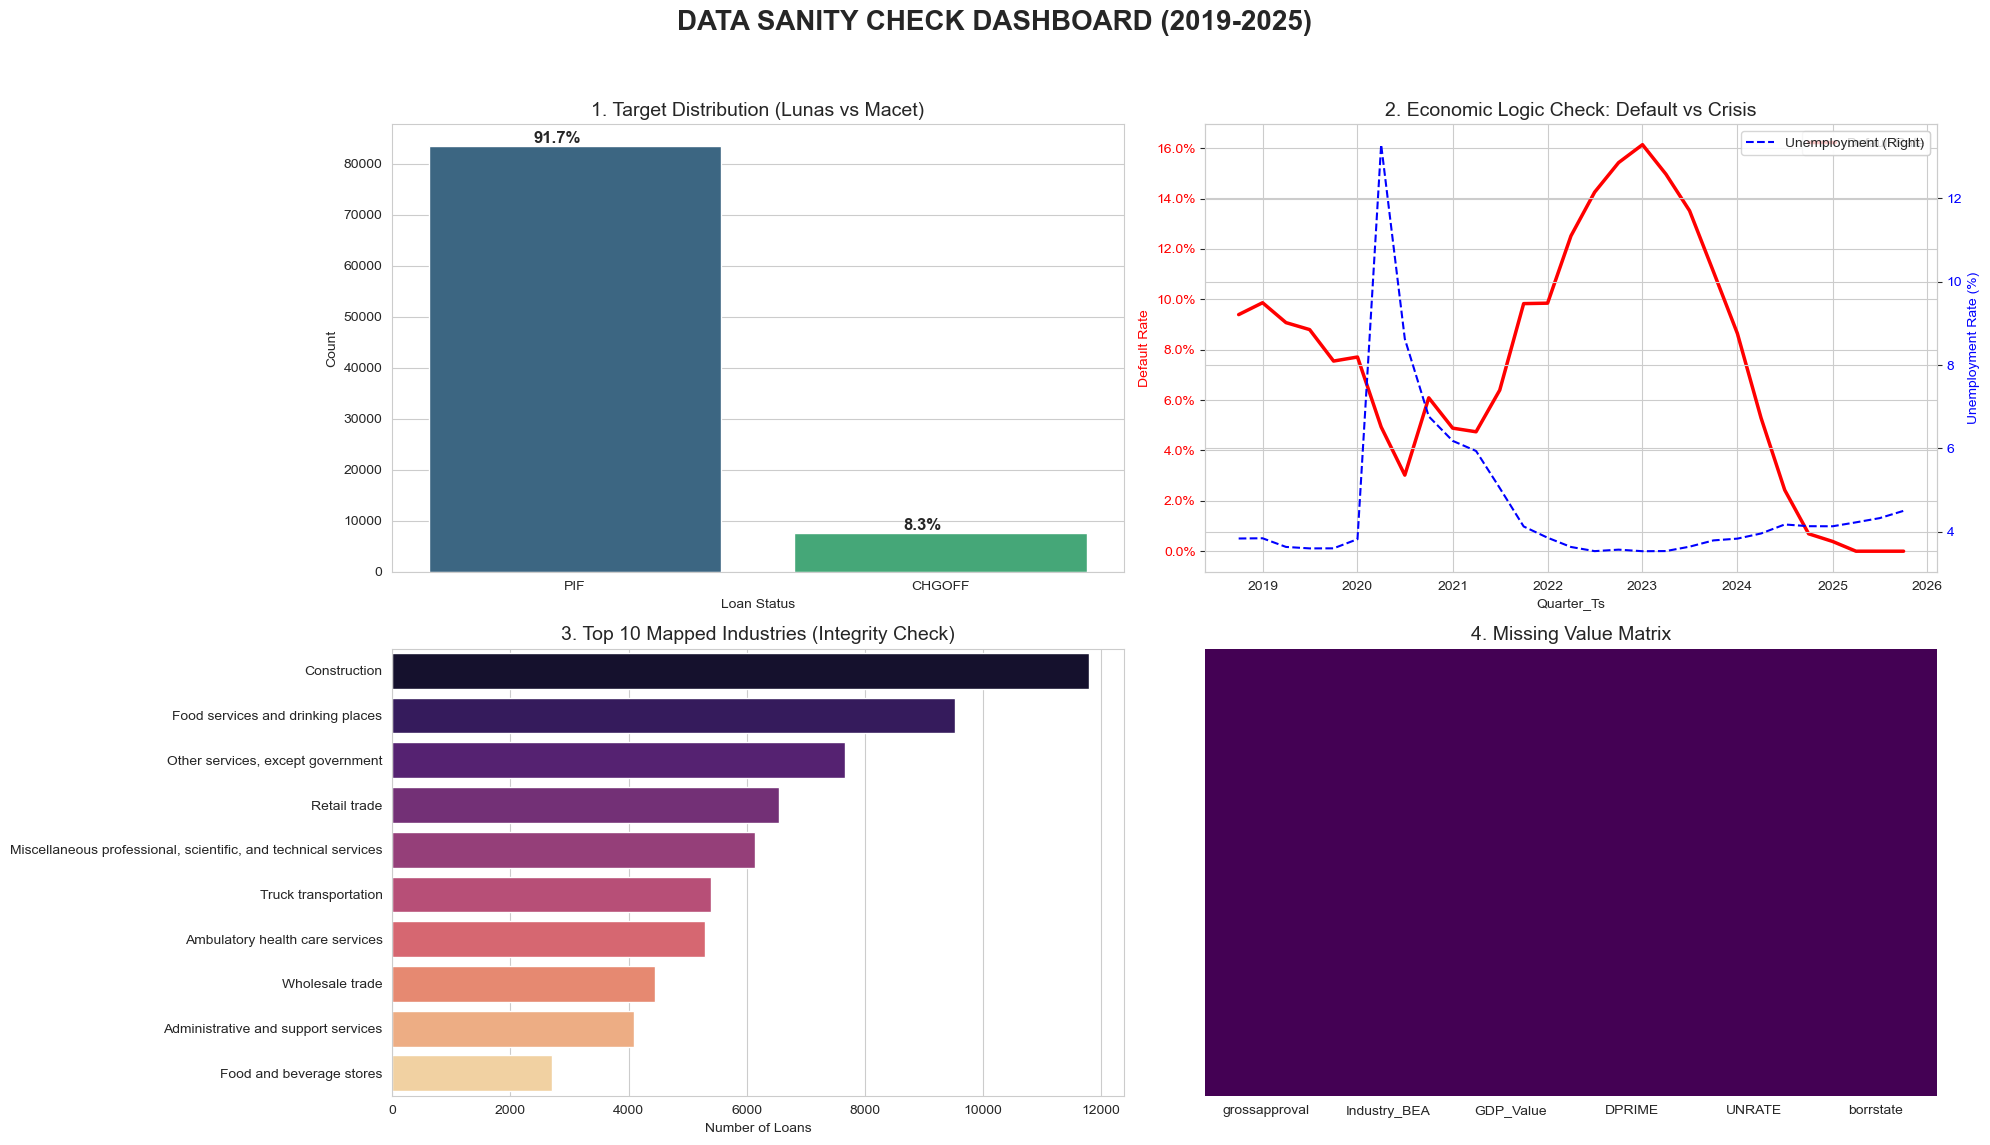

Total Data Bersih: 91,211 baris
Default Rate Global: 8.34%
Periode Data: 2018-10-01 s/d 2025-11-19


In [45]:
valid_status = ['PIF', 'CHGOFF']
data_clean = data_clean[data_clean['loanstatus'].isin(valid_status)].copy()
data_clean['is_default'] = (data_clean['loanstatus'] == 'CHGOFF').astype(int)

# Setup Visualisasi
sns.set_style("whitegrid")
plt.figure(figsize=(20, 12))
plt.suptitle('DATA SANITY CHECK DASHBOARD (2019-2025)', fontsize=20, weight='bold')

#Chart 1
plt.subplot(2, 2, 1)
ax1 = sns.countplot(data=data_clean, x='loanstatus', palette='viridis', order=['PIF', 'CHGOFF'])
plt.title("1. Target Distribution (Lunas vs Macet)", fontsize=14)
plt.xlabel("Loan Status")
plt.ylabel("Count")

# Tambah Label Persentase
total = len(data_clean)
for p in ax1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax1.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, weight='bold')

#Chart 2
plt.subplot(2, 2, 2)

data_clean['Quarter'] = data_clean['approvaldate'].dt.to_period('Q')
macro_trend = data_clean.groupby('Quarter').agg({
    'is_default': 'mean', 
    'UNRATE': 'mean'
}).reset_index()
macro_trend['Quarter_Ts'] = macro_trend['Quarter'].dt.to_timestamp()

ax2 = sns.lineplot(data=macro_trend, x='Quarter_Ts', y='is_default', color='red', label='Default Rate', linewidth=2.5)
ax2.set_ylabel("Default Rate", color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) # Format %

ax2_twin = ax2.twinx()
sns.lineplot(data=macro_trend, x='Quarter_Ts', y='UNRATE', color='blue', ax=ax2_twin, linestyle='--', label='Unemployment (Right)')
ax2_twin.set_ylabel("Unemployment Rate (%)", color='blue')
ax2_twin.tick_params(axis='y', labelcolor='blue')
plt.title("2. Economic Logic Check: Default vs Crisis", fontsize=14)


# Chart 3
plt.subplot(2, 2, 3)
top_industries = data_clean['Industry_BEA'].value_counts().head(10).index
sns.countplot(data=data_clean[data_clean['Industry_BEA'].isin(top_industries)], y='Industry_BEA', 
              palette='magma', order=top_industries)
plt.title("3. Top 10 Mapped Industries (Integrity Check)", fontsize=14)
plt.xlabel("Number of Loans")
plt.ylabel("")


# Chart 4
plt.subplot(2, 2, 4)
cols_to_check = ['grossapproval', 'Industry_BEA', 'GDP_Value', 'DPRIME', 'UNRATE', 'borrstate']
sns.heatmap(data_clean[cols_to_check].isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("4. Missing Value Matrix", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

save_path = f"{CONFIG['data_paths']['visualization']} Sanity_Check_Dashboard_v1.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

clean_total = len(data_clean)
default_rate_global = data_clean['is_default'].mean()

print(f"Total Data Bersih: {len(data_clean):,} baris")
print(f"Default Rate Global: {data_clean['is_default'].mean():.2%}")
print(f"Periode Data: {data_clean['approvaldate'].min().date()} s/d {data_clean['approvaldate'].max().date()}")

last_run = mlflow.last_active_run()

if last_run :
    with mlflow.start_run(run_id=last_run.info.run_id) :
        
        mlflow.log_metric("total_clean_rows", clean_total)
        mlflow.log_metric("clean_default_rate", default_rate_global)
        mlflow.log_artifact(save_path, artifact_path='visualization')

## Hypothesis Testing (Confirmation Data Analytics)

### Analysis The Sectoral Shock

Corellation GDP vs NPL : -0.382
P-Value:  0.045 (if < 0.05 is significant)


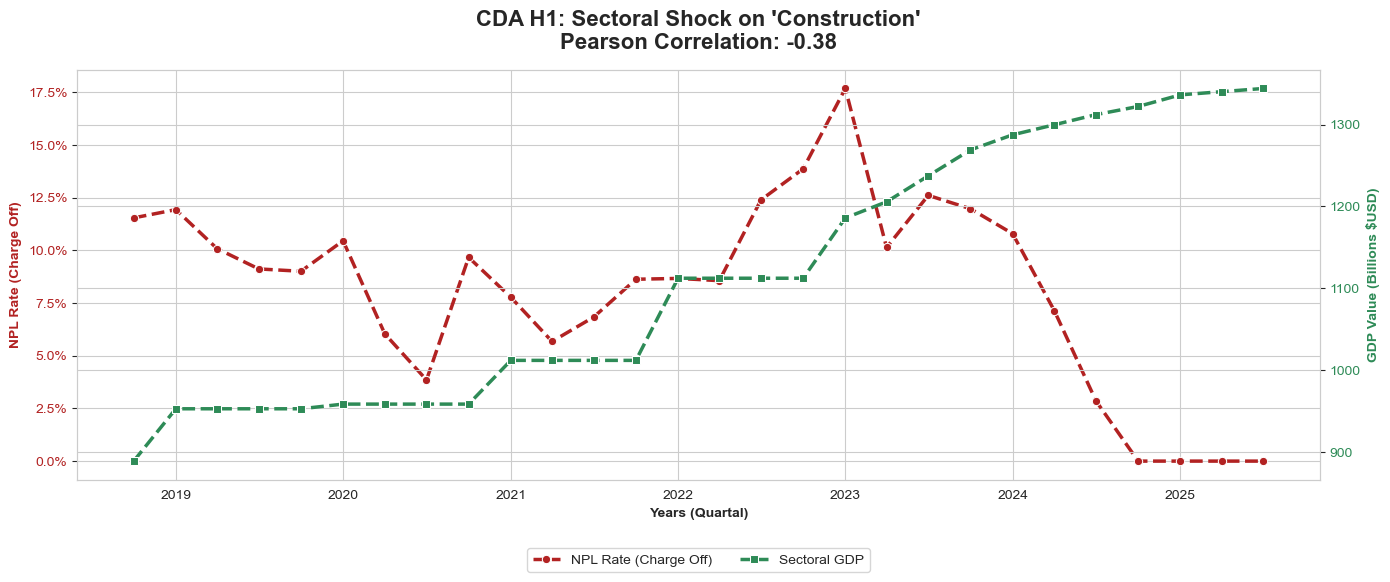


 [Hypothesis Accepted!] There is a strong negative correlation. When GDP falls, NPLs rise significantly. This is a valid risk driver!


In [46]:
## Data Prep
data_clean['is_default'] = (data_clean['loanstatus'] == 'CHGOFF').astype(int)
# Filter a the larger industry
top_industries = data_clean['Industry_BEA'].value_counts().index[0]
filter_industries = data_clean[data_clean['Industry_BEA'] == top_industries].copy()

# Group Quarter and find mean GDP_Value and is_default (NPL %)
filter_industries['Quarter'] = filter_industries['approvaldate'].dt.to_period('Q')
industry_trend = filter_industries.groupby('Quarter').agg({
    'is_default': 'mean',  # Rata-rata NPL (%)
    'GDP_Value': 'mean'    # Rata-rata GDP
}).reset_index()

# Convert to Timestamp
industry_trend['Quarter_Ts'] = industry_trend['Quarter'].dt.to_timestamp()

## Statistic 
corr, p_val = pearsonr(industry_trend['GDP_Value'], industry_trend['is_default'])
print(f"Corellation GDP vs NPL : {corr: .3f}")
print(f"P-Value: {p_val: .3f} (if < 0.05 is significant)")

## Visualisasi Dual-Axis

#setup canvas
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(14,6))

# plot 1 NPL Rate
sns.lineplot(data=industry_trend, x='Quarter_Ts', y='is_default', ax=ax1,
             color='firebrick',linewidth=2.5, linestyle='--', marker='o', label='NPL Rate (Charge Off)')
ax1.set_ylabel("NPL Rate (Charge Off)", color='firebrick', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='firebrick')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) # Percent
ax1.set_xlabel("Years (Quartal)", fontweight='bold')

# Plot 2 GDP Values
ax2=ax1.twinx()
sns.lineplot(data=industry_trend, x='Quarter_Ts', y ='GDP_Value', ax=ax2,
             color='seagreen', linewidth=2.5, linestyle='--', marker='s', label='Sectoral GDP')
ax2.set_ylabel("GDP Value (Billions $USD)", color='seagreen', fontweight='bold')
ax2.tick_params(axis='y',labelcolor='seagreen')

plt.title(f"CDA H1: Sectoral Shock on '{top_industries}'\nPearson Correlation: {corr: .2f}",
          fontsize=16, fontweight='bold', pad=15)

# Asembly anything

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
ax2.get_legend().remove()
plt.tight_layout()

save_path = f"{CONFIG['data_paths']['visualization']} H1_Sectoral_Shock.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

if corr < -0.3:
    print("\n [Hypothesis Accepted!] There is a strong negative correlation. When GDP falls, NPLs rise significantly. This is a valid risk driver!")
elif corr > 0.3:
    print("\n [Anomaly H1] There is Positive Correlation. NPLs actually rise when GDP rises. Further investigation is needed. ")
else :
    print("\n[Hypothesis Rejected] The correlation is very weak (approaching 0). GDP shocks in this sector do not appear to significantly affect customer defaults. ")
    

with mlflow.start_run(run_name="Hypothesis_Testing_v2.2"):
    mlflow.log_artifact(save_path,artifact_path='visualization')
    mlflow.log_metric('Correlation GDP vs NPL', corr)
    mlflow.log_metric('P_Value', p_val)
    
    mlflow.log_param('H1_conclusion', '[Hypothesis Accepted!] There is a strong negative correlation. When GDP falls, NPLs rise significantly. This is a valid risk driver!')



### Analysis Customer Squeeze (Unemployment Rate vs NPL)

Correlation Unemployment Rate vs NPL: -0.329
P_value:  0.081


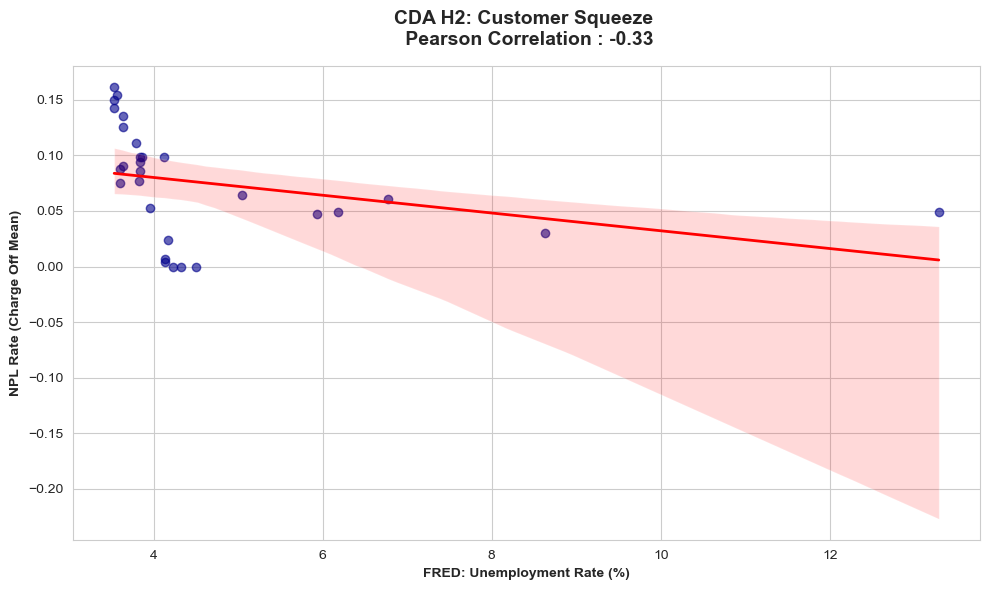


[Hypothesis Rejected/Weak] Weak correlation. Unemployment does not appear to be strongly linearly correlated with NPL in this data.
[MLOps] H2 saved to MLflow


In [47]:
data_clean['Quarter'] = data_clean['approvaldate'].dt.to_period('Q')
unrate = data_clean.groupby('Quarter').agg({
    'is_default' : 'mean',
    'UNRATE' : 'mean'
}).reset_index()

unrate['Quarter_Ts'] = unrate['Quarter'].dt.to_timestamp()

corr2, p_val2 = pearsonr(unrate['UNRATE'], unrate['is_default'])
print(f"Correlation Unemployment Rate vs NPL: {corr2: .3f}")
print(f"P_value: {p_val2: .3f}")

sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(10,6))


sns.regplot(data=unrate, x='UNRATE', y='is_default', 
            scatter_kws={'alpha':0.6, 'color':'darkblue'},
            line_kws={'color':'red', 'linewidth':2})


plt.title(f"CDA H2: Customer Squeeze \n Pearson Correlation : {corr2: .2f}", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("FRED: Unemployment Rate (%)", fontweight='bold')
plt.ylabel("NPL Rate (Charge Off Mean)", fontweight='bold')
plt.tight_layout()


save_path_h2 = f"{CONFIG['data_paths']['visualization']}H2_Consumer_Squeeze.png"
plt.savefig(save_path_h2, dpi=300, bbox_inches='tight')
plt.show()

if corr2 > 0.3:
    print("\n[Hypothesis Accepted!] There is a positive correlation. When unemployment rises, NPLs tend to rise as well.")
else:
    print("\n[Hypothesis Rejected/Weak] Weak correlation. Unemployment does not appear to be strongly linearly correlated with NPL in this data.")

last_run = mlflow.last_active_run()

if last_run:
    with mlflow.start_run(run_id=last_run.info.run_id):
        mlflow.log_artifact(save_path_h2, artifact_path='visualization') 
        mlflow.log_metric('h2_correlation_unrate_npl', corr2)
        mlflow.log_metric('h2_p_value', p_val2)
    
    print("[MLOps] H2 saved to MLflow")


### Analysis Interest Rate Effect

=== Analysis H3: Interest Rate Effect (Prime Rate) ===


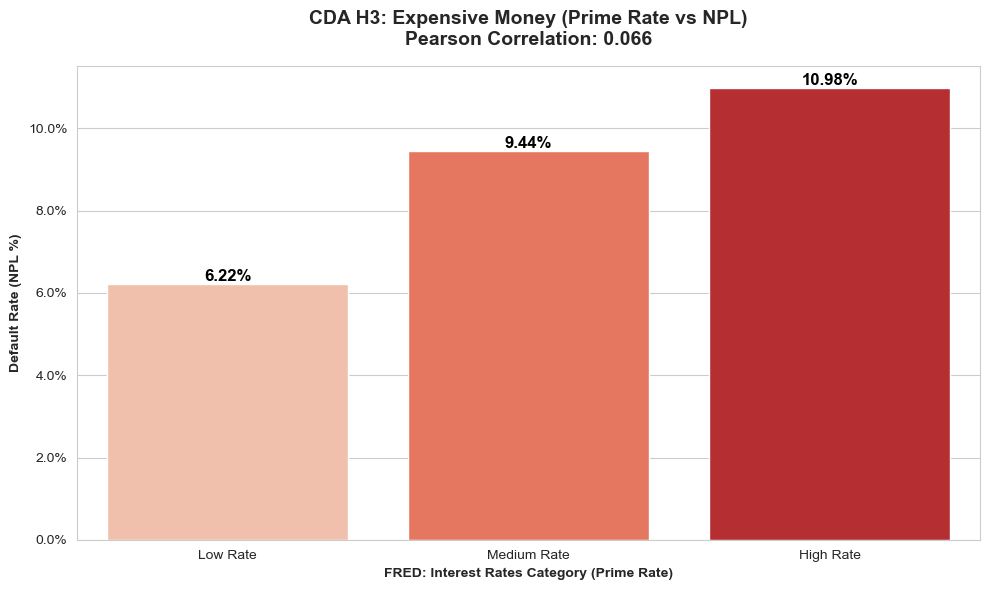


[Hypothesis Accepted!] NPLs on high interest rates are greater than those on low interest rates. Capital costs trigger defaults.
[MLOps] H3 tersimpan di MLflow.


In [48]:
print("=== Analysis H3: Interest Rate Effect (Prime Rate) ===")

data_clean['DPRIME_Category'] = pd.cut(data_clean['DPRIME'], bins=[0, 4.0, 7.0, 20.0], labels=['Low Rate', 'Medium Rate', 'High Rate'])

h3_trend = data_clean.groupby('DPRIME_Category').agg({
    'is_default': 'mean',
    'DPRIME': 'count' # Untuk melihat sebaran data
}).rename(columns={'DPRIME': 'Total_Loans'}).reset_index()

corr3, p_val3 = pearsonr(data_clean['DPRIME'], data_clean['is_default'])

# Bar Chart
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=h3_trend, x='DPRIME_Category', y='is_default', palette='Reds')

plt.title(f"CDA H3: Expensive Money (Prime Rate vs NPL)\nPearson Correlation: {corr3:.3f}", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("FRED: Interest Rates Category (Prime Rate)", fontweight='bold')
plt.ylabel("Default Rate (NPL %)", fontweight='bold')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Tambah label angka di atas bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2%}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.tight_layout()

# Simpan Gambar
save_path_h3 = f"{CONFIG['data_paths']['visualization']}H3_Expensive_Money.png"
plt.savefig(save_path_h3, dpi=300, bbox_inches='tight')
plt.show()

if h3_trend.loc[2, 'is_default'] > h3_trend.loc[0, 'is_default']:
    print("\n[Hypothesis Accepted!] NPLs on high interest rates are greater than those on low interest rates. Capital costs trigger defaults.")
else:
    print("\n[Hypothesis Rejected] Needed More Investigation!.")

last_run = mlflow.last_active_run()

if last_run:
    with mlflow.start_run(run_id=last_run.info.run_id):
        mlflow.log_artifact(save_path_h3, artifact_path='visualization')
        mlflow.log_metric('h3_correlation_dprime_npl', corr3)
        mlflow.log_param('h3_highest_risk_category', h3_trend.loc[h3_trend['is_default'].idxmax(), 'DPRIME_Category'])
        print("[MLOps] H3 tersimpan di MLflow.")

=== Cross-Correlation Analysis: Lag Effect of Prime Rate on NPL ===


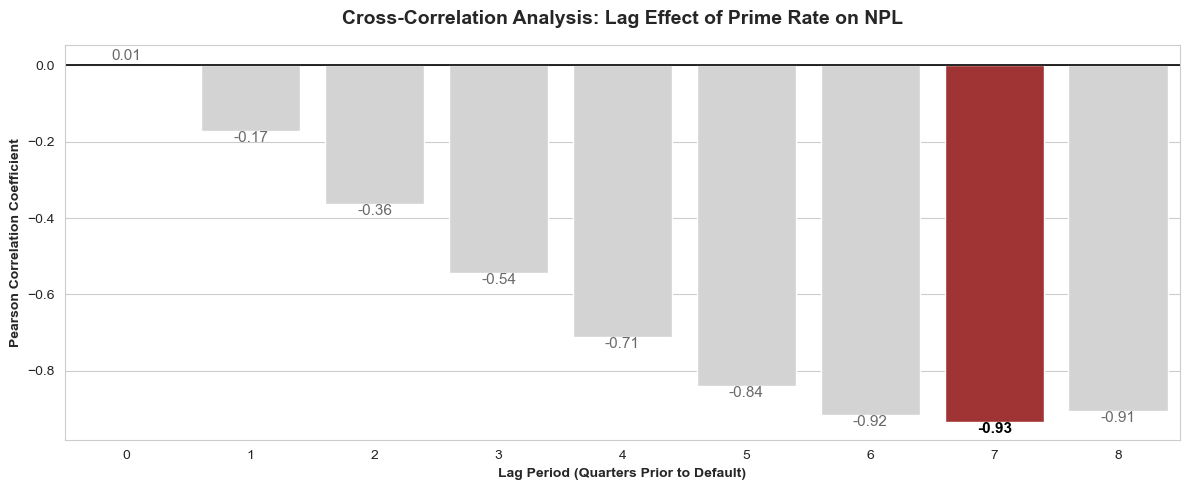

In [49]:
print("=== Cross-Correlation Analysis: Lag Effect of Prime Rate on NPL ===")

data_clean['Quarter'] = data_clean['approvaldate'].dt.to_period('Q')
quarterly_macro = data_clean.groupby('Quarter').agg({
    'is_default': 'mean',  
    'DPRIME': 'mean'       
}).reset_index()

# Hitung Lag (0 sampai 8 Kuartal)
lags = range(0, 9) 
correlations = []
for lag in lags:
    valid_data = pd.DataFrame({
        'NPL': quarterly_macro['is_default'],
        'Prime_Lagged': quarterly_macro['DPRIME'].shift(lag)
    }).dropna()
    corr, _ = pearsonr(valid_data['Prime_Lagged'], valid_data['NPL'])
    correlations.append(corr)

df_lag_corr = pd.DataFrame({'Lag_Quarters': lags, 'Correlation': correlations})
best_lag_idx = df_lag_corr['Correlation'].abs().idxmax()
best_lag_val = int(df_lag_corr.loc[best_lag_idx, 'Lag_Quarters'])

sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 5))

colors = ['firebrick' if i == best_lag_idx else 'lightgray' for i in df_lag_corr.index]

sns.barplot(data=df_lag_corr, x='Lag_Quarters', y='Correlation', palette=colors, ax=ax1)
ax1.axhline(0, color='black', linewidth=1.2)

plt.title("Cross-Correlation Analysis: Lag Effect of Prime Rate on NPL", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Lag Period (Quarters Prior to Default)", fontweight='bold')
plt.ylabel("Pearson Correlation Coefficient", fontweight='bold')

for p, i in zip(ax1.patches, df_lag_corr.index):
    weight = 'bold' if i == best_lag_idx else 'normal'
    color_text = 'black' if i == best_lag_idx else 'dimgray'
    ax1.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom' if p.get_height() > 0 else 'top', 
                fontsize=11, fontweight=weight, color=color_text)

plt.tight_layout()
save_path_lag = f"{CONFIG['data_paths']['visualization']}H3_Cross_Correlation_Analysis.png"
plt.savefig(save_path_lag, dpi=300, bbox_inches='tight')
plt.show()


last_run = mlflow.last_active_run()
if last_run:
    with mlflow.start_run(run_id=last_run.info.run_id):
        mlflow.log_artifact(save_path_lag, artifact_path='visualization')

=== Chronological Time-Series Analysis: Natural Lag Observation ===


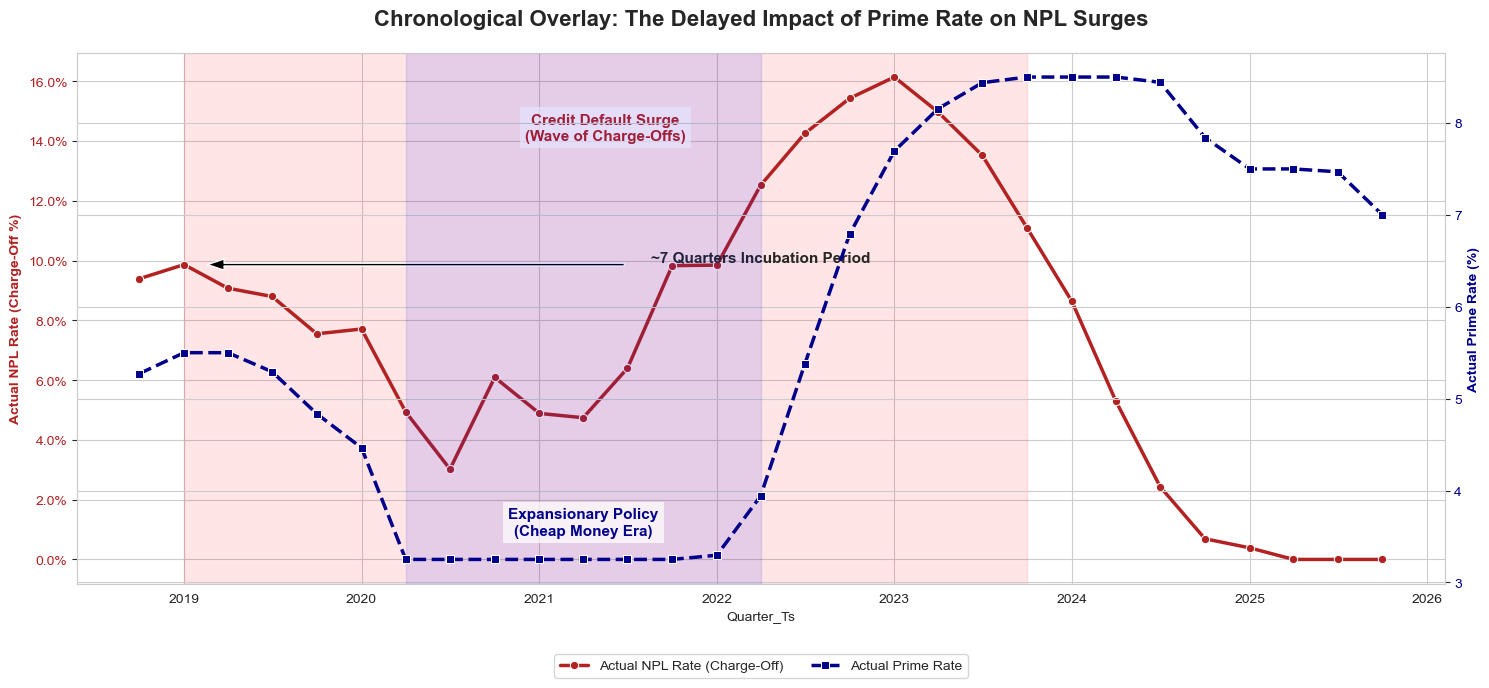

[STRONG INVERSE LAG OBSERVED] Correlation: -0.93 at Lag 7 according to H3.

Conclusion: The time-series visualization clearly demonstrates a 'Delayed Risk Manifestation' (Lag Effect).
Periods of aggressive expansionary policy (Prime Rates dropping significantly) directly trigger an influx of high-risk loan approvals.
These high-risk loans do not default immediately; they experience an incubation period of approximately 7 quarters (21 months).
Once the initial capital runs out, a massive 'Credit Default Surge' occurs.

 [MLOps] Natural Timeline Chart has been successfully logged to the active run.


In [50]:
print("=== Chronological Time-Series Analysis: Natural Lag Observation ===")

# 1. Agregasi Murni (TANPA DIGESER)
data_clean['Quarter'] = data_clean['approvaldate'].dt.to_period('Q')
quarterly_macro = data_clean.groupby('Quarter').agg({
    'is_default': 'mean',  
    'DPRIME': 'mean'       
}).reset_index()

quarterly_macro['Quarter_Ts'] = quarterly_macro['Quarter'].dt.to_timestamp()

lags = range(0, 9) 
correlations = [pearsonr(pd.DataFrame({'NPL': quarterly_macro['is_default'], 'Prime': quarterly_macro['DPRIME'].shift(lag)}).dropna()['Prime'], 
                         pd.DataFrame({'NPL': quarterly_macro['is_default'], 'Prime': quarterly_macro['DPRIME'].shift(lag)}).dropna()['NPL'])[0] for lag in lags]
best_lag_val = int(pd.DataFrame({'Lag': lags, 'Corr': correlations}).loc[pd.Series(correlations).abs().idxmax(), 'Lag'])
best_lag_corr = pd.Series(correlations).loc[pd.Series(correlations).abs().idxmax()]

sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot 1: Current NPL Rate (Sumbu Kiri)
sns.lineplot(data=quarterly_macro, x='Quarter_Ts', y='is_default', ax=ax1, 
             color='firebrick', linewidth=2.5, marker='o', label='Actual NPL Rate (Charge-Off)')
ax1.set_ylabel("Actual NPL Rate (Charge-Off %)", color='firebrick', fontweight='bold')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.tick_params(axis='y', labelcolor='firebrick')

# Plot 2: Actual Prime Rate (Sumbu Kanan)
ax2 = ax1.twinx()
sns.lineplot(data=quarterly_macro, x='Quarter_Ts', y='DPRIME', ax=ax2, 
             color='darkblue', linewidth=2.5, linestyle='--', marker='s', label='Actual Prime Rate')
ax2.set_ylabel("Actual Prime Rate (%)", color='darkblue', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='darkblue')

low_rate_mask = quarterly_macro['DPRIME'] <= 4.0
if low_rate_mask.any():
    start_low = quarterly_macro[low_rate_mask]['Quarter_Ts'].iloc[0]
    end_low = quarterly_macro[low_rate_mask]['Quarter_Ts'].iloc[-1]
    ax2.axvspan(start_low, end_low, color='blue', alpha=0.1)
    ax2.text(start_low + (end_low - start_low)/2, ax2.get_ylim()[0] + 0.5, 
             'Expansionary Policy\n(Cheap Money Era)', color='darkblue', 
             fontsize=11, fontweight='bold', ha='center', va='bottom', 
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

npl_threshold = quarterly_macro['is_default'].quantile(0.75)
high_npl_mask = quarterly_macro['is_default'] >= npl_threshold
if high_npl_mask.any():
    start_npl = quarterly_macro[high_npl_mask]['Quarter_Ts'].iloc[0]
    end_npl = quarterly_macro[high_npl_mask]['Quarter_Ts'].iloc[-1]
    ax1.axvspan(start_npl, end_npl, color='red', alpha=0.1)
    ax1.text(start_npl + (end_npl - start_npl)/2, ax1.get_ylim()[1] - 0.02, 
             'Credit Default Surge\n(Wave of Charge-Offs)', color='firebrick', 
             fontsize=11, fontweight='bold', ha='center', va='top', 
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

if low_rate_mask.any() and high_npl_mask.any():
    ax1.annotate(f'~{best_lag_val} Quarters Incubation Period', 
                 xy=(start_npl, npl_threshold), 
                 xytext=(end_low, npl_threshold),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8),
                 fontsize=11, fontweight='bold', ha='center', va='bottom')

plt.title("Chronological Overlay: The Delayed Impact of Prime Rate on NPL Surges", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Timeline (Years)", fontweight='bold')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2)
ax2.get_legend().remove()

plt.tight_layout()

# Simpan Gambar
save_path_ts_natural = f"{CONFIG['data_paths']['visualization']}H3_Natural_Timeline_Analysis.png"
plt.savefig(save_path_ts_natural, dpi=300, bbox_inches='tight')
plt.show()


if best_lag_corr <= -0.5:
    print(f"[STRONG INVERSE LAG OBSERVED] Correlation: {best_lag_corr:.2f} at Lag {best_lag_val} according to H3.")
    print("\nConclusion: The time-series visualization clearly demonstrates a 'Delayed Risk Manifestation' (Lag Effect).")
    print(f"Periods of aggressive expansionary policy (Prime Rates dropping significantly) directly trigger an influx of high-risk loan approvals.")
    print(f"These high-risk loans do not default immediately; they experience an incubation period of approximately {best_lag_val} quarters ({best_lag_val * 3} months).")
    print("Once the initial capital runs out, a massive 'Credit Default Surge' occurs.")

elif best_lag_corr > 0.5:
    print(f"[STRONG DIRECT LAG OBSERVED] Correlation: {best_lag_corr:.2f} at Lag {best_lag_val}.")
    print("\nConclusion: High interest rates eventually crush business cash flows, leading to defaults several quarters later.")
else:
    print(f"[WEAK RELATIONSHIP] Maximum Correlation: {best_lag_corr:.2f}.")
    print("\nConclusion: Macroeconomic interest rates do not show a distinct chronological impact on NPL in this specific dataset.")


last_run = mlflow.last_active_run()
if last_run:
    with mlflow.start_run(run_id=last_run.info.run_id):
        mlflow.log_artifact(save_path_ts_natural, artifact_path='visualization')
        print("\n [MLOps] Natural Timeline Chart has been successfully logged to the active run.")

### Analysis Gross Approval

=== Analysis H4: The Impact of Loan Size ===


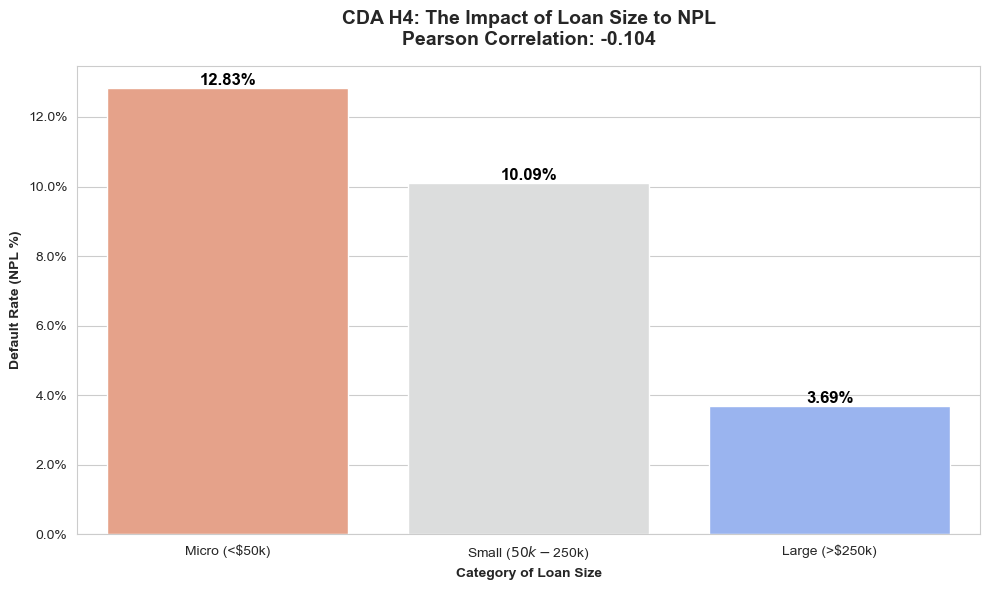


[Hypothesis Accepted!] A negative correlation has been proven. The smaller the loan amount, the higher the percentage of defaults.
[MLOps] H4 tersimpan di MLflow.


In [51]:
print("=== Analysis H4: The Impact of Loan Size ===")

# Binning Nilai Pinjaman
def categorize_loan(amount):
    if amount < 50000:
        return 'Micro (<$50k)'
    elif amount <= 250000:
        return 'Small ($50k - $250k)'
    else:
        return 'Large (>$250k)'

data_clean['Loan_Size_Category'] = data_clean['grossapproval'].apply(categorize_loan)

h4_trend = data_clean.groupby('Loan_Size_Category').agg({
    'is_default': 'mean',
}).reset_index()

order_cat = ['Micro (<$50k)', 'Small ($50k - $250k)', 'Large (>$250k)']
corr4, p_val4 = pearsonr(data_clean['grossapproval'], data_clean['is_default'])

# Bar Chart
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=h4_trend, x='Loan_Size_Category', y='is_default', order=order_cat, palette='coolwarm_r')

plt.title(f"CDA H4: The Impact of Loan Size to NPL\nPearson Correlation: {corr4:.3f}", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Category of Loan Size", fontweight='bold')
plt.ylabel("Default Rate (NPL %)", fontweight='bold')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2%}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.tight_layout()

save_path_h4 = f"{CONFIG['data_paths']['visualization']}H4_Size_Matters.png"
plt.savefig(save_path_h4, dpi=300, bbox_inches='tight')
plt.show()

if corr4 < 0:
    print("\n[Hypothesis Accepted!] A negative correlation has been proven. The smaller the loan amount, the higher the percentage of defaults.")
else:
    print("\n[Hypothesis Rejected] The amount of the loan is directly proportional to the default rate, or is not correlated.")

last_run = mlflow.last_active_run()

if last_run:
    with mlflow.start_run(run_id=last_run.info.run_id):
        mlflow.log_artifact(save_path_h4, artifact_path='visualization')
        mlflow.log_metric('h4_correlation_size_npl', corr4)
        print("[MLOps] H4 tersimpan di MLflow.")

### Analysis Geographic Risk

=== Analysis H5: GEOGRAPHIC RISK (State) ===


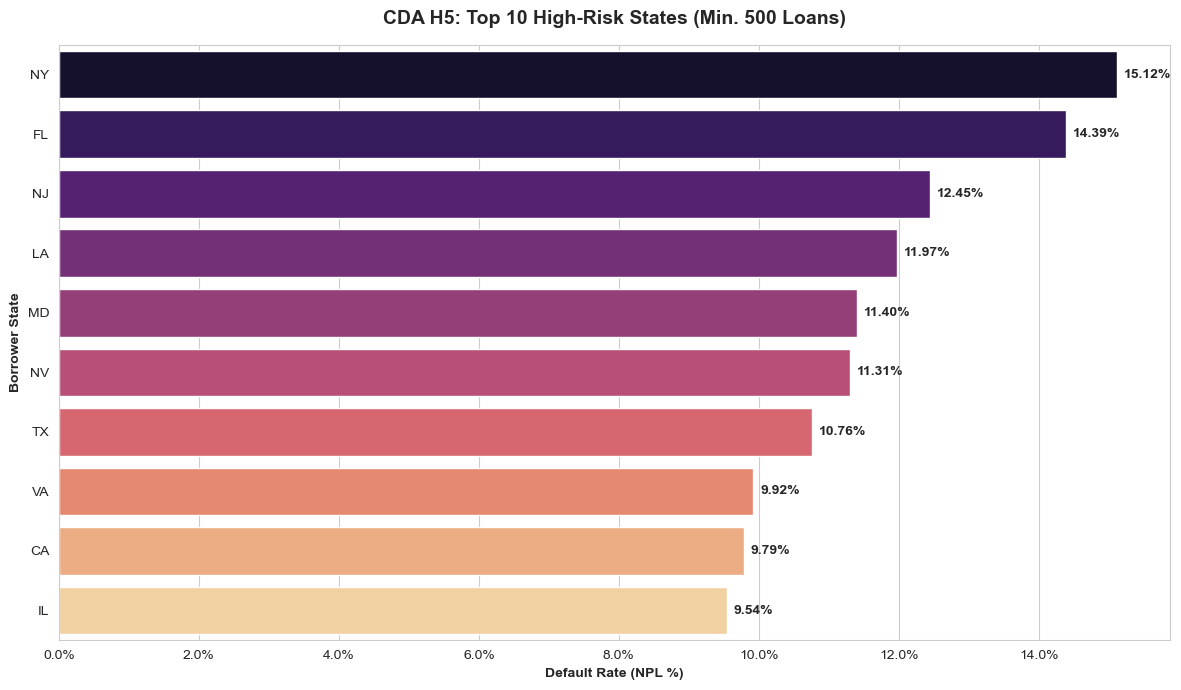


[Insight H5]: State NY leading the highest NPL risk of 15.12%.
[MLOps] H5 tersimpan di MLflow.


In [52]:
print("=== Analysis H5: GEOGRAPHIC RISK (State) ===")

h5_trend = data_clean.groupby('borrstate').agg({
    'is_default': 'mean',
    'grossapproval': 'count'
}).rename(columns={'grossapproval': 'Total_Borrowers'}).reset_index()

h5_valid = h5_trend[h5_trend['Total_Borrowers'] > 500].copy()
top_10_states = h5_valid.sort_values(by='is_default', ascending=False).head(10)

# Horizontal Bar Chart
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))

sns.barplot(data=top_10_states, x='is_default', y='borrstate', palette='magma')

plt.title("CDA H5: Top 10 High-Risk States (Min. 500 Loans)", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Default Rate (NPL %)", fontweight='bold')
plt.ylabel("Borrower State", fontweight='bold')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Tambah label angka di ujung bar
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f"{width:.2%}", (width, p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')

plt.tight_layout()

# Simpan Gambar
save_path_h5 = f"{CONFIG['data_paths']['visualization']}H5_Geographic_Risk.png"
plt.savefig(save_path_h5, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n[Insight H5]: State {top_10_states.iloc[0]['borrstate']} leading the highest NPL risk of {top_10_states.iloc[0]['is_default']:.2%}.")

last_run = mlflow.last_active_run()

if last_run:
    with mlflow.start_run(run_id=last_run.info.run_id):
        mlflow.log_artifact(save_path_h5, artifact_path='visualization')
        mlflow.log_param('h5_highest_risk_state', top_10_states.iloc[0]['borrstate'])
        mlflow.log_metric('h5_highest_state_npl', top_10_states.iloc[0]['is_default'])
        print("[MLOps] H5 tersimpan di MLflow.") 

### Analysis Short Leash

=== Analysis H6: Tenor (Loan Term) ===


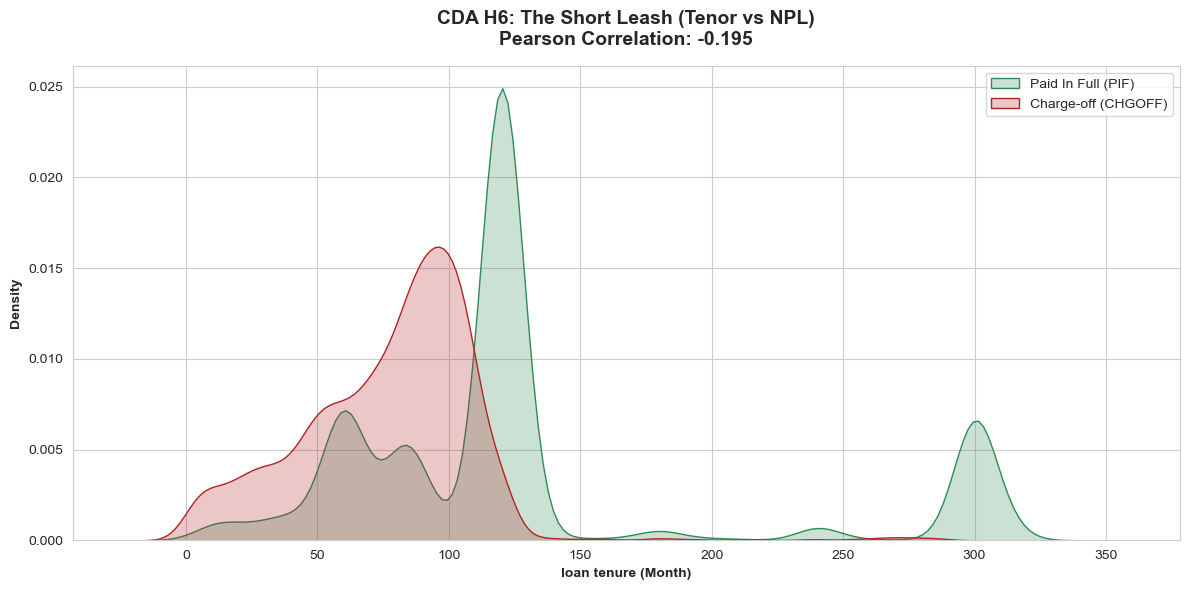


[Hypothesis Accepted!] The red curve (Stagnant) is stacked on the left (Short Tenor). Short tenor is very risky!
[MLOps] H6 tersimpan di MLflow.


In [53]:
print("=== Analysis H6: Tenor (Loan Term) ===")

# Filter Outliers (Fokus pada tenor normal <= 360 bulan / 30 tahun)
df_h6 = data_clean[data_clean['terminmonths'] <= 360].copy()
corr6, p_val6 = pearsonr(df_h6['terminmonths'], df_h6['is_default'])


sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=df_h6[df_h6['is_default'] == 0]['terminmonths'], fill=True, color='seagreen', label='Paid In Full (PIF)')
sns.kdeplot(data=df_h6[df_h6['is_default'] == 1]['terminmonths'], fill=True, color='firebrick', label='Charge-off (CHGOFF)')

plt.title(f"CDA H6: The Short Leash (Tenor vs NPL)\nPearson Correlation: {corr6:.3f}", fontsize=14, fontweight='bold', pad=15)
plt.xlabel("loan tenure (Month)", fontweight='bold')
plt.ylabel("Density", fontweight='bold')
plt.legend()

plt.tight_layout()

save_path_h6 = f"{CONFIG['data_paths']['visualization']}H6_Short_Leash.png"
plt.savefig(save_path_h6, dpi=300, bbox_inches='tight')
plt.show()

# Kesimpulan & MLOps
if corr6 < -0.1:
    print("\n[Hypothesis Accepted!] The red curve (Stagnant) is stacked on the left (Short Tenor). Short tenor is very risky!")
else:
    print("\n[Hypothesis Rejected/Weak] The loan term does not have a strong linear correlation with NPL.")

last_run = mlflow.last_active_run()

if last_run:
    with mlflow.start_run(run_id=last_run.info.run_id):
            mlflow.log_artifact(save_path_h6, artifact_path='visualization')
            mlflow.log_metric('h6_correlation_tenor_npl', corr6)
            print("[MLOps] H6 tersimpan di MLflow.")